#task:
#1 dif types of noize
#Выбрать произвольное изображение. Получить искаженные различными шумами изображения с помощью функции 
noise с отличными от значений по умолчанию параметрами.

#2 Low-pass filtering
#Обработать полученные в предыдущем пункте искаженные изображения фильтром
#Гаусса и контргармоническим усредняющим фильтром с различными значениями параметра 𝑄.

#3 Nonlinear filtering
#Обработать полученные в первом пункте искаженные изображения медианной, взвешенной медианной, 
#ранговой и винеровской фильтрациями при различных размерах маски и ее коэффициентов. 
#Реализовать адаптивную медианную фильтрацию.

#4 High-pass filtering
#Выбрать исходное изображение. Выделить границы фильтрами Робертса, Превитта, Собела, Лапласа, алгоритмом Кэнни.

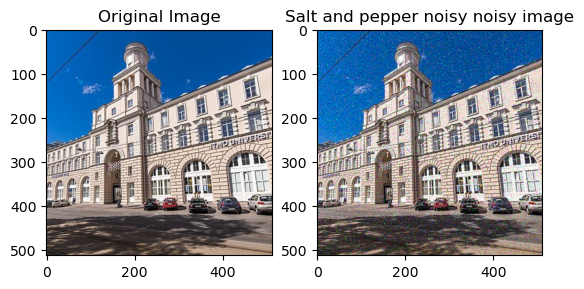

In [14]:
#1) dif types of noize

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Image upload
image_path = "C:\\Users\\vs410\\Downloads\\ITMO_University's_main_building,_August_2016 (1).jpg"
image_1 = cv2.imread(image_path)


# 1)
def add_salt_and_pepper_noise(image_1, salt_prob, pepper_prob):
    # Noise parameters
    d = 0.05  # Density of the noise
    s_vs_p = salt_prob / (salt_prob + pepper_prob)  # Ratio of salt to pepper

    # Generate random numbers
    rng = np.random.default_rng()
    noise = rng.random(image_1.shape)

    # Salt
    image_noisy = np.copy(image_1)
    image_noisy[noise < d * s_vs_p] = 255

    # Pepper
    image_noisy[np.logical_and(noise >= d * s_vs_p, noise < d)] = 0

    return image_noisy


salt_prob = 0.5 # Adjust as needed
pepper_prob = 0.5  # Adjust as needed
noisy_image = add_salt_and_pepper_noise(image_1, salt_prob, pepper_prob)

# original and nisy images
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
plt.title('Salt and pepper noisy noisy image')

plt.show()

0.01
0.1


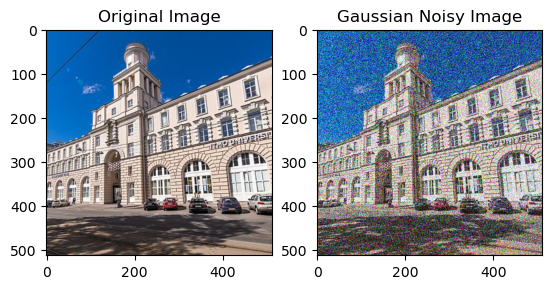

In [3]:
def add_gaussian_noise(image_1, mean, var):
    # Generate random numbers
    rng = np.random.default_rng()
    gauss = rng.normal(mean, var ** 0.5, image_1.shape)
    gauss = gauss.reshape(image_1.shape)
    
    # Process uchar and float images separately
    if image_1.dtype == np.uint8:
        gaussian_noisy_image = (image_1.astype(np.float32) + gauss * 255).clip(0, 255).astype(np.uint8)
    else:
        gaussian_noisy_image = (image_1 + gauss).astype(np.float32)

    return gaussian_noisy_image

# Пример использования
mean = float(input())
var = float(input())
image_1 = cv2.imread(image_path)
gaussian_noisy_image = add_gaussian_noise(image_1, mean, var)

# Отображение оригинального и зашумленного изображений
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(gaussian_noisy_image, cv2.COLOR_BGR2RGB))
plt.title('Gaussian Noisy Image')

plt.show()

0.5


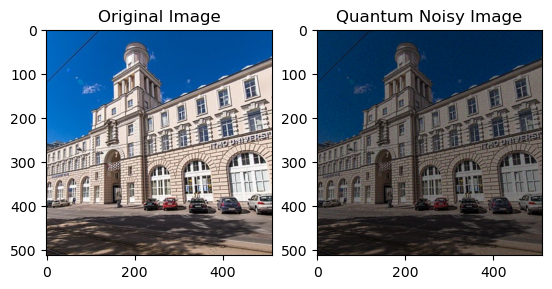

In [24]:
#Poisson(Quantum)_noisy
def add_poisson_noise(image_1, noise_level):
    rng = np.random.default_rng()

    if image_1.dtype == np.uint8:
        image_p = image_1.astype(np.float32) / 255
        vals = len(np.unique(image_p))
        vals = 2**np.ceil(np.log2(vals))
        poisson_noise_image = (255 * (rng.poisson(image_p * vals * noise_level) / float(vals)).clip(0, 1)).astype(np.uint8)
    else:
        vals = len(np.unique(image_1))
        vals = 2**np.ceil(np.log2(vals))
        poisson_noise_image = rng.poisson(image_1 * vals * noise_level) / float(vals)

    return poisson_noise_image

# Пример использования
image_path = "C:\\Users\\vs410\\Downloads\\ITMO_University's_main_building,_August_2016 (1).jpg"
original_image = cv2.imread(image_path)

# Запрос уровня шума у пользователя
noise_level = float(input())

# Добавление Пуассоновского шума с указанным уровнем
poisson_noisy_image = add_poisson_noise(original_image, noise_level)

# Отображение оригинального и зашумленного изображений
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(poisson_noisy_image, cv2.COLOR_BGR2RGB))
plt.title('Quantum Noisy Image')

plt.show()


LOW_PASS_FILTERING

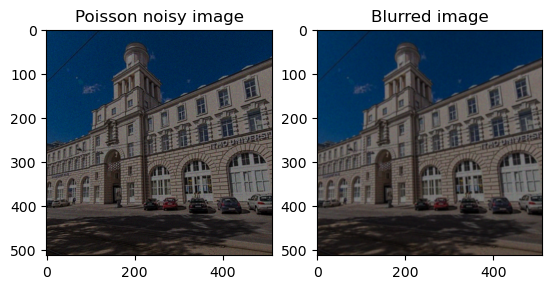

In [25]:
# Применение фильтра Гаусса
sigma = 1.0  # Параметр сглаживания (стандартное отклонение)
blurred_image = cv2.GaussianBlur(image, (0, 0), sigma)

image = poisson_noisy_image
# Отображение оригинального и сглаженного изображений
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(poisson_noisy_image, cv2.COLOR_BGR2RGB))
plt.title('Poisson noisy image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.title('Blurred image')

plt.show()


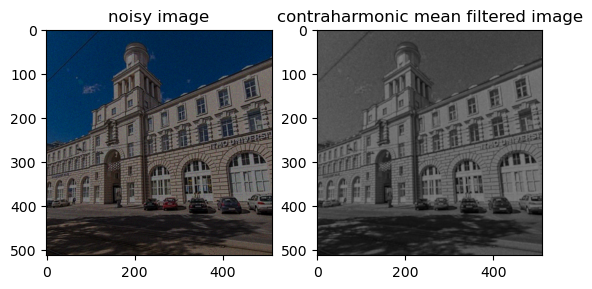

In [28]:

def contraharmonic_mean_filter_with_mask(image_with_noise, mask, Q):
    padded_image = cv2.copyMakeBorder(image_with_noise, 1, 1, 1, 1, cv2.BORDER_CONSTANT)
    result_image = np.zeros_like(image_with_noise, dtype=np.float64) # массив нулей для нового изображения
    
    for i in range(1, padded_image.shape[0] - 1):
        for j in range(1, padded_image.shape[1] - 1): # с помощью цикла проходимся по каждому элементу массива 
            neighborhood = padded_image[i-1:i+2, j-1:j+2] * mask # окрестность с использованием маски
            numerator = np.sum(np.power(neighborhood, Q+1)) # числитель в формуле
            denominator = np.sum(np.power(neighborhood, Q)) # знаменатель в формуле
            result_image[i-1, j-1] = numerator / denominator

    return result_image.astype(np.uint8)

# Загрузка изображения (замените на свое изображение)
image_with_noise = poisson_noisy_image

# Создание маски
mask = np.float64([[1, 1, 1], [1, 1, 1], [1, 1, 1]])

# Применение контргармонического усреднения с маской
сontraharmonic_mean_filtered_image = contraharmonic_mean_filter_with_mask(image_with_noise, mask, Q=1.5).astype(np.uint8)

# Вывод изображений
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(poisson_noisy_image, cv2.COLOR_BGR2RGB))
plt.title('noisy image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(сontraharmonic_mean_filtered_image, cv2.COLOR_BGR2RGB))
plt.title('сontraharmonic mean filtered image')

plt.show()


НЕЛИНЕЙНАЯ ФИЛЬТРАЦИЯ 

Введите размер ядра5


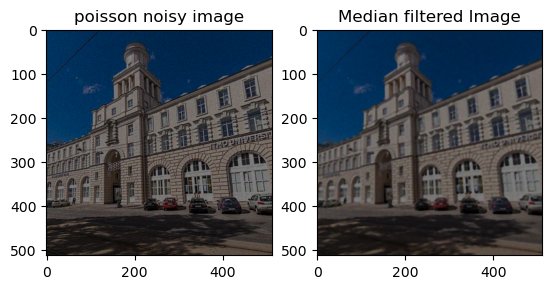

In [34]:
#median
# Определение размера ядра (окрестности) для медианного фильтра
ksize = int(input('Введите размер ядра'))
image = poisson_noisy_image
# Применение медианного фильтра
median_filtered_image = cv2.medianBlur(image, ksize)

# Вывод изображений
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('poisson noisy image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(median_filtered_image, cv2.COLOR_BGR2RGB))
plt.title('Median filtered Image')

plt.show()


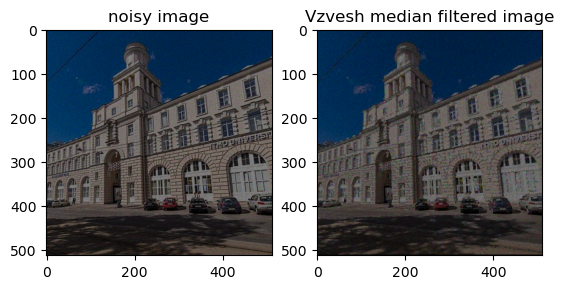

In [76]:
# vzvesh_median
def vzvesh_median_filter(image, kernel_size, weights):
    rows, cols, channels = image.shape
    half_kernel = kernel_size // 2
    output_image = np.zeros_like(image, dtype=np.uint8)

    for c in range(channels):
        for i in range(half_kernel, rows - half_kernel):
            for j in range(half_kernel, cols - half_kernel):
                window = image[i - half_kernel:i + half_kernel + 1, j - half_kernel:j + half_kernel + 1, c]
                flat_window = window.flatten()

                # Applying weights to the window
                weighted_window = flat_window * weights.flatten()

                # Finding the index of the median value in the sorted weighted window
                median_index = np.argsort(weighted_window)[len(weighted_window) // 2]

                # Assigning the median value to the output pixel
                output_image[i, j, c] = flat_window[median_index]

    return output_image

# Load your noisy image
image = poisson_noisy_image
kernel_size = 3
weights = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) 

vzvesh_median_filtered_image = vzvesh_median_filter(image, kernel_size, weights)

# Display the images
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Noisy image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(vzvesh_median_filtered_image, cv2.COLOR_BGR2RGB))
plt.title('Vzvesh median filtered image')

plt.show()


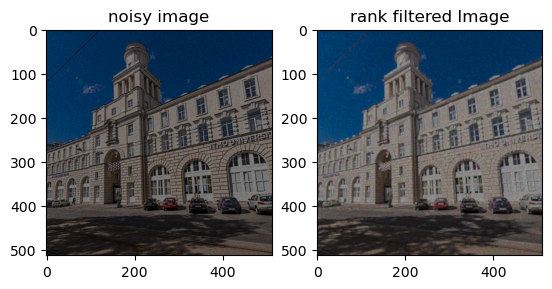

In [66]:
#rank
image = poisson_noisy_image
# Filter parameters

k_size = (3, 3)
rank = 8
kernel = np.ones(k_size, dtype=np.float32)
rows, cols = image.shape[0:2]


if image.dtype == np.uint8:
    image_copy = image.astype(np.float32) / 255
else:
    image_copy = image

image_copy = cv2.copyMakeBorder(image_copy,
                            int((k_size[0] - 1) / 2),
                            int(k_size[0] / 2),
                            int((k_size[1] - 1) / 2),
                            int(k_size[1] / 2),
                            cv2.BORDER_REPLICATE)

# Fill arrays for each kernel item
image_layers = np.zeros(image.shape + (k_size[0] * k_size[1],), dtype=np.float32)

if image.ndim == 2:
    for i in range(k_size[0]):
        for j in range(k_size[1]):
            image_layers[:, :, i * k_size[1] + j] = kernel[i, j] * image_copy[i: i + rows, j: j + cols]
else:
    for i in range(k_size[0]):
        for j in range(k_size[1]):
            image_layers[:, :, :, i * k_size[1] + j] = kernel[i, j] * image_copy[i: i + rows, j: j + cols, :]

# Sort arrays
image_layers.sort()

# Choose layer with rank
if image.ndim == 2:
    rank_filtered_image = image_layers[:, :, rank]
else:
    rank_filtered_image = image_layers[:, :, :, rank]

# Convert back to uint if needed
if image.dtype == np.uint8:
    rank_filtered_image = (255 * rank_filtered_image).clip(0, 255).astype(np.uint8)

#вывод изображения
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('noisy image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(rank_filtered_image, cv2.COLOR_BGR2RGB))
plt.title('rank filtered Image')

plt.show()

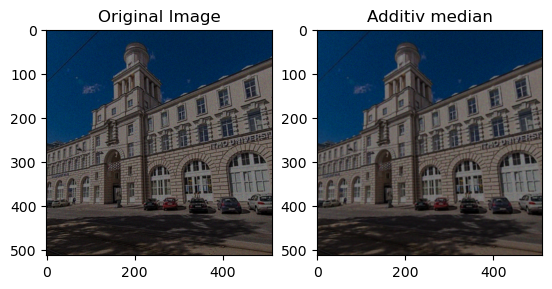

In [85]:
#additiv_median
image = poisson_noisy_image
def additiv_median_filter(image, max_window_size):
    rows, cols, channels = image.shape
    filtered_image = np.empty_like(image, dtype=np.uint8)  # Используем np.empty_like

    for i in range(rows):
        for j in range(cols):
            window_size = 3
            while window_size <= max_window_size:
                window = image[max(0, i - window_size//2):min(rows, i + window_size//2 + 1),
                               max(0, j - window_size//2):min(cols, j + window_size//2 + 1), :]

                z_min = np.min(window, axis=(0, 1))
                z_max = np.max(window, axis=(0, 1))
                z_med = np.median(window, axis=(0, 1))
                A1 = z_med - z_min
                A2 = z_med - z_max

                if np.all(A1 > 0) and np.all(A2 < 0):
                    B1 = image[i, j, :] - z_min
                    B2 = image[i, j, :] - z_max

                    if np.all(B1 > 0) and np.all(B2 < 0):
                        filtered_image[i, j, :] = image[i, j, :]  # Задаем значения цветовых каналов
                    else:
                        filtered_image[i, j, :] = z_med
                    break
                else:
                    window_size += 2

            if window_size > max_window_size:
                filtered_image[i, j, :] = image[i, j, :]  # Задаем значения цветовых каналов

    return filtered_image

# Пример использования:
image = poisson_noisy_image
max_window_size = 7 

filtered_image = additiv_median_filter(image, max_window_size)

# Отображение изображений
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Noisy Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
plt.title('Additiv median')

plt.show()


Высокочастотная фильтрация

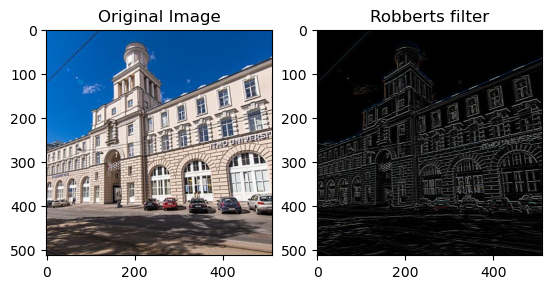

In [53]:
#Robberts
# Загрузка цветного изображения
def Roberts_filt(image_1):
    
    # Разделение на каналы
    b, g, r = cv2.split(image_1)

    # Определение операторов Робертса
    G_x = np.array([[1, 0], [0, -1]])
    G_y = np.array([[0, 1], [-1, 0]])

    # Применение операторов Робертса к каждому каналу
    r_x = cv2.filter2D(r, -1, G_x).astype(np.float32)
    r_y = cv2.filter2D(r, -1, G_y).astype(np.float32)

    g_x = cv2.filter2D(g, -1, G_x).astype(np.float32)
    g_y = cv2.filter2D(g, -1, G_y).astype(np.float32)

    b_x = cv2.filter2D(b, -1, G_x).astype(np.float32)
    b_y = cv2.filter2D(b, -1, G_y).astype(np.float32)

# Вычисление магнитуды градиентов для каждого канала
    r_out = cv2.magnitude(r_x, r_y)
    g_out = cv2.magnitude(g_x, g_y)
    b_out = cv2.magnitude(b_x, b_y)

# Нормализация значений
    cv2.normalize(r_out, r_out, 0, 1, cv2.NORM_MINMAX)
    cv2.normalize(g_out, g_out, 0, 1, cv2.NORM_MINMAX)
    cv2.normalize(b_out, b_out, 0, 1, cv2.NORM_MINMAX)

# Объединение каналов
    result_image = cv2.merge([r_out, g_out, b_out])

# Вывод изображений
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(result_image)
plt.title('Robberts filter')

plt.show()



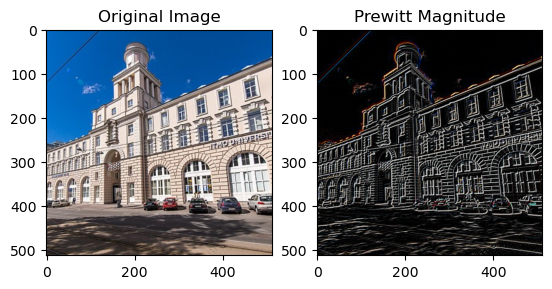

In [46]:
#Previtt
# Разделение на каналы
b, g, r = cv2.split(image_1)

# Определение операторов Прюитта
G_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
G_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

# Применение операторов Прюитта к каждому каналу
r_x = cv2.filter2D(r, -1, G_x).astype(np.float32)
r_y = cv2.filter2D(r, -1, G_y).astype(np.float32)

g_x = cv2.filter2D(g, -1, G_x).astype(np.float32)
g_y = cv2.filter2D(g, -1, G_y).astype(np.float32)

b_x = cv2.filter2D(b, -1, G_x).astype(np.float32)
b_y = cv2.filter2D(b, -1, G_y).astype(np.float32)

# Вычисление магнитуды градиентов для каждого канала
r_out = cv2.magnitude(r_x, r_y)
g_out = cv2.magnitude(g_x, g_y)
b_out = cv2.magnitude(b_x, b_y)

# Нормализация значений
cv2.normalize(r_out, r_out, 0, 1, cv2.NORM_MINMAX)
cv2.normalize(g_out, g_out, 0, 1, cv2.NORM_MINMAX)
cv2.normalize(b_out, b_out, 0, 1, cv2.NORM_MINMAX)

# Объединение каналов
result_image = cv2.merge([r_out, g_out, b_out])

# Вывод изображений
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(result_image)
plt.title('Previtt filter')

plt.show()


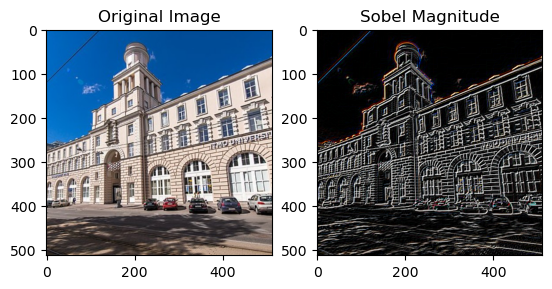

In [48]:
#Sobel

# Определение операторов Собеля
G_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
G_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Применение операторов Собеля к каждому каналу
r_x = cv2.filter2D(r, -1, G_x).astype(np.float32)
r_y = cv2.filter2D(r, -1, G_y).astype(np.float32)

g_x = cv2.filter2D(g, -1, G_x).astype(np.float32)
g_y = cv2.filter2D(g, -1, G_y).astype(np.float32)

b_x = cv2.filter2D(b, -1, G_x).astype(np.float32)
b_y = cv2.filter2D(b, -1, G_y).astype(np.float32)

# Вычисление магнитуды градиентов для каждого канала
r_out = cv2.magnitude(r_x, r_y)
g_out = cv2.magnitude(g_x, g_y)
b_out = cv2.magnitude(b_x, b_y)

# Нормализация значений
cv2.normalize(r_out, r_out, 0, 1, cv2.NORM_MINMAX)
cv2.normalize(g_out, g_out, 0, 1, cv2.NORM_MINMAX)
cv2.normalize(b_out, b_out, 0, 1, cv2.NORM_MINMAX)

# Объединение каналов
result_image = cv2.merge([r_out, g_out, b_out])

# Вывод изображений
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(result_image)
plt.title('Sobel filter')

plt.show()


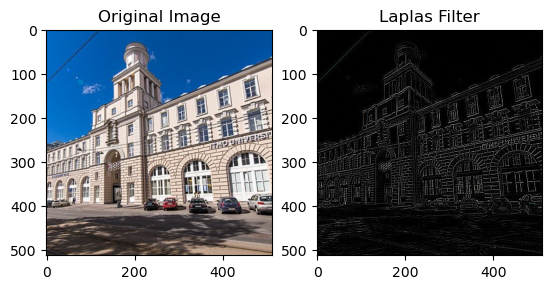

In [55]:
#Laplas
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Определение ядра Лапласа
laplas_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

# Применение фильтра Лапласа к каждому каналу
r_laplas = cv2.filter2D(r, -1, laplacian_kernel).astype(np.float32)
g_laplas = cv2.filter2D(g, -1, laplacian_kernel).astype(np.float32)
b_laplas = cv2.filter2D(b, -1, laplacian_kernel).astype(np.float32)

# Вычисление абсолютных значений градиента для каждого канала
r_out = np.abs(r_laplas)
g_out = np.abs(g_laplas)
b_out = np.abs(b_laplas)

# Нормализация значений
cv2.normalize(r_out, r_out, 0, 1, cv2.NORM_MINMAX)
cv2.normalize(g_out, g_out, 0, 1, cv2.NORM_MINMAX)
cv2.normalize(b_out, b_out, 0, 1, cv2.NORM_MINMAX)

# Объединение каналов
result_image = cv2.merge([r_out, g_out, b_out])

# Вывод изображений
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(result_image)
plt.title('Laplas Filter')

plt.show()


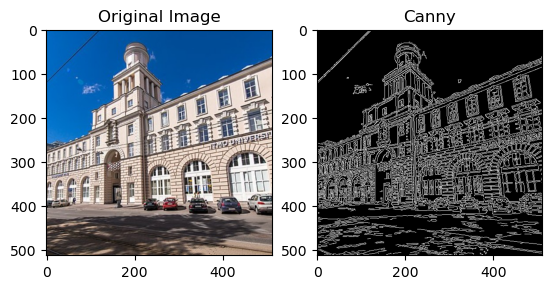

In [86]:
#Canny
# Применение оператора Canny
t1 = 100  # Нижний порог
t2 = 200  # Верхний порог
canny = cv2.Canny(image_1, t1, t2)

# Вывод изображения
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(canny, cmap='gray')
plt.title('Canny Filter')

plt.show()